<a href="https://colab.research.google.com/github/LerinaMM/bitcoin_series_temporais_projecao/blob/main/bitcoin_series_temporais_com_monte_carlo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dashboard Mercado Financeiro

1. Vamos utilizar o Yahoo Finance para captar dados do mercado financeiro

In [1]:
!pip install yfinance --upgrade --no-cache-dir

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.2/63.2 kB 5.4 MB/s eta 0:00:00
  Attempting uninstall: yfinance
    Found existing installation: yfinance 0.2.21
    Uninstalling yfinance-0.2.21:
      Successfully uninstalled yfinance-0.2.21


## 2. Chamada de bibliotecas

In [2]:
# Pacotes para análises de dados
import pandas as pd
import pandas_datareader.data as web
import numpy as np

# Pacotes para análises gráficas
import matplotlib.pyplot as plt
import matplotlib as m
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

#Função para data
from datetime import datetime

# Pacotes para calculos estatísticos
import scipy

#YFinance (dados do mercado financeiro)
import yfinance as yf
yf.pdr_override()

#Avisos
import warnings
warnings.filterwarnings("ignore")

# Imports para formatação dos dados
plt.style.use('fivethirtyeight')
m.rcParams['axes.labelsize'] = 14
m.rcParams['xtick.labelsize'] = 12
m.rcParams['ytick.labelsize'] = 12
m.rcParams['text.color'] = 'k'

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10

# Formatando valores com duas casas decimais
pd.options.display.float_format = '{:.2f}'.format


##3. API Yahoo Finance

O YFinance oferece uma maneira segmentada e Pythonic de baixar dados do mercado do Yahoo finanças

In [3]:
#Coletando dados da API da Yahoo Finance - Buscamos o código do ativo e escolhemos o período a ser analisado
#Exemplos de períodos de tempos: (1d, 5d, 3mo, 6mo, 1y, 2y, 5y e ytd)
Dados = web.get_data_yahoo('BTC-USD', period='1y' )

#Shape
Dados.shape

[*********************100%***********************]  1 of 1 completed


(366, 6)

Dentro dos dados temos 1240 linhas e 6 colunas

In [4]:
#Verificando os dados
Dados.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-07-09,21716.83,21877.14,21445.96,21592.21,21592.21,29641127858
2022-07-10,21591.08,21591.08,20727.12,20860.45,20860.45,28688807249
2022-07-11,20856.35,20856.35,19924.54,19970.56,19970.56,24150249025
2022-07-12,19970.47,20043.45,19308.53,19323.91,19323.91,25810220018
2022-07-13,19325.97,20223.05,18999.95,20212.07,20212.07,33042430345


In [5]:
# Registros mais recentes
Dados.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-07-05,30778.72,30877.33,30225.61,30514.17,30514.17,12481622280
2023-07-06,30507.15,31460.05,29892.23,29909.34,29909.34,21129219509
2023-07-07,29908.00,30434.64,29777.29,30342.27,30342.27,13384770155
2023-07-08,30346.92,30374.44,30080.16,30292.54,30292.54,7509378699
2023-07-09,30304.69,30398.36,30250.90,30284.29,30284.29,7387105792


In [6]:
#Retirando a Coluna - Adj Close

#Dados.drop('Adj Close', axis=1, inplace=True)

#Renomeando as colunas

Dados.columns = ['Abertura', 'Maximo', 'Minimo', 'Fechamento', 'Fechamento_1', 'Volume']

In [7]:
#Observar o range de dados

print('Menor data:', Dados.index.min())
print('Maior data:', Dados.index.max())

Menor data: 2022-07-09 00:00:00
Maior data: 2023-07-09 00:00:00


In [8]:
#Vamos observar os dados referentes a ultima data do conjunto de dados
#Utilizaremos esses dados mais adiante para compor os parâmetros a simulação de Monte Carlo

display(Dados.loc[Dados.index.max()])

Abertura            30304.69
Maximo              30398.36
Minimo              30250.90
Fechamento          30284.29
Fechamento_1        30284.29
Volume         7387105792.00
Name: 2023-07-09 00:00:00, dtype: float64

In [9]:
# Calculando o percentual de mudança na cotação de fechamento diario das ações
# Ou seja, quanto o valor de fechamento varia de um dia para o outro, o retorno diário da ação
# O comando pct_change() vai pegar a data do dia anterior, e vai calcular a variação entre o dia anterior e o dia atual.
# Estamos criando um novo dataframe chamado retorno_diario
# O comando dropna será utilizado para caso houvere valores nulos

retorno_diario = Dados['Fechamento'].pct_change().dropna()
retorno_diario.head


<bound method NDFrame.head of Date
2022-07-10   -0.03
2022-07-11   -0.04
2022-07-12   -0.03
2022-07-13    0.05
2022-07-14    0.02
              ... 
2023-07-05   -0.01
2023-07-06   -0.02
2023-07-07    0.01
2023-07-08   -0.00
2023-07-09   -0.00
Name: Fechamento, Length: 365, dtype: float64>

In [13]:
#Vamos agora unir os dois dataframes com o comando merge, utilizando a coluna data como variável em comum

Dados = pd.merge(Dados, retorno_diario, how = 'inner', on = 'Date')
Dados.colunms = ['Abertura', 'Maximo', 'Minimo', 'Fechamento', 'Fechamento_1' 'Volume', 'Variacao_Diaria']
Dados.head()

,Abertura,Maximo,Minimo,Fechamento_x,Fechamento_1,Volume,Fechamento_y
Date,,,,,,,
2022-07-10,21591.08,21591.08,20727.12,20860.45,20860.45,28688807249,-0.03
2022-07-11,20856.35,20856.35,19924.54,19970.56,19970.56,24150249025,-0.04
2022-07-12,19970.47,20043.45,19308.53,19323.91,19323.91,25810220018,-0.03
2022-07-13,19325.97,20223.05,18999.95,20212.07,20212.07,33042430345,0.05
2022-07-14,20211.47,20789.89,19689.26,20569.92,20569.92,31158743333,0.02


In [10]:
#Estatística descritiva
Dados.describe()

,Abertura,Maximo,Minimo,Fechamento,Fechamento_1,Volume
count,366.00,366.00,366.00,366.00,366.00,366.00
mean,22763.06,23165.87,22396.21,22787.45,22787.45,25408636367.24
std,4292.74,4390.50,4232.77,4312.16,4312.16,13020907007.84
min,15782.30,16253.05,15599.05,15787.28,15787.28,7044911360.00
25%,19390.00,19648.38,19106.09,19390.57,19390.57,16104886590.75
50%,22466.68,22991.48,22047.02,22547.43,22547.43,23573590385.50
75%,26852.39,27255.59,26593.77,26864.08,26864.08,31254109036.50
max,31156.87,31460.05,30659.36,31156.44,31156.44,118992465607.00


In [11]:
#Informação dos dados
Dados.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 366 entries, 2022-07-09 to 2023-07-09
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Abertura      366 non-null    float64
 1   Maximo        366 non-null    float64
 2   Minimo        366 non-null    float64
 3   Fechamento    366 non-null    float64
 4   Fechamento_1  366 non-null    float64
 5   Volume        366 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 28.1 KB


In [62]:
#Media Movel - Equilibrio de preços do mercado, para verificar o equilibrio dos preços no mercado, observando tendência de alta, média e baixa
# É um indicador importante que suaviza os dados dos preços das ações para formar um indicador que segue a tendência.

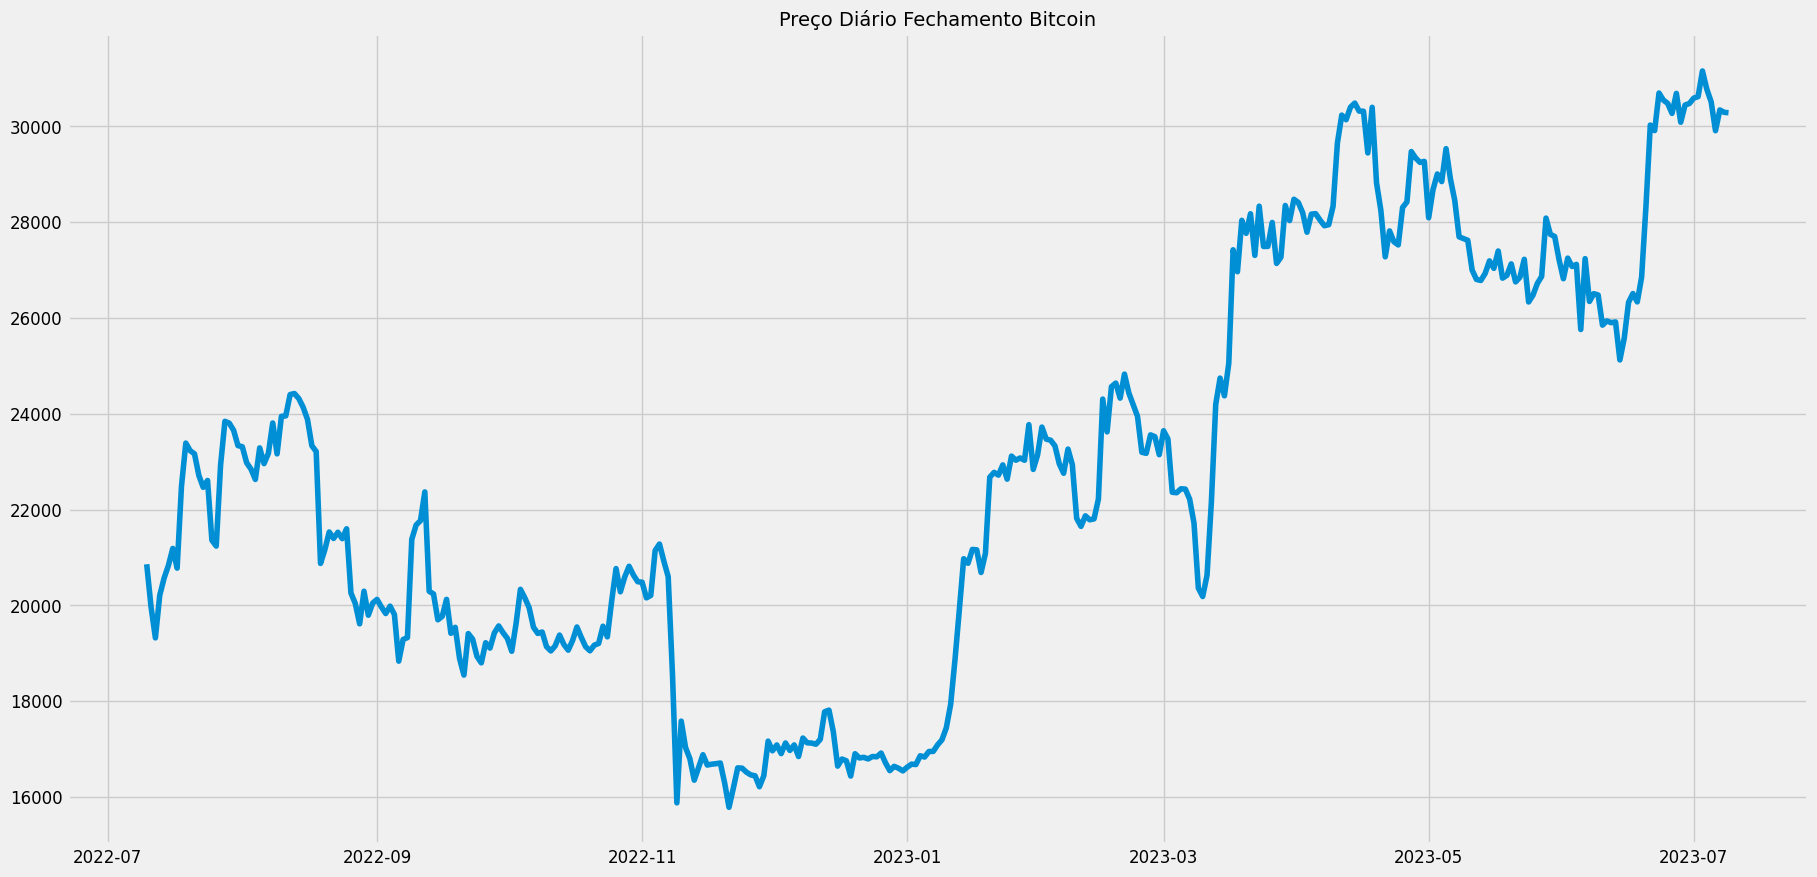

In [14]:
#Plotar os dados
plt.plot (Dados['Fechamento_x'])
plt.title('Preço Diário Fechamento Bitcoin', size = 14);
plt.show()

In [15]:
#Retorno acumulado (vamos utilizar para a projeção de tendência em seguida)

retorno_diario_acumulado = (1 + retorno_diario).cumprod() - 1
retorno_diario_acumulado.max()

0.4429483474307594

# Analise exploratória e estatística descritiva

In [16]:
# Média do fechamento diário da cotação das ações

media_retorno_diario = np.mean(retorno_diario)

In [17]:
# Desvio padrão do fechamento diário da cotação das ações

desvio_retorno_diario = np.std(retorno_diario)

In [18]:
# Valores de média e desvio padrão

print("Média do preço de fechamento", media_retorno_diario)
print("Desvio Padrão do Retorno de fechamento", desvio_retorno_diario)

Média do preço de fechamento 0.001297056790127359
Desvio Padrão do Retorno de fechamento 0.027189842244097755


Vamos considerar que um ano de 365 dias de funcionamento de um criptoativo. Caso seja uma ação normal, devemos considerar somente 252 dias do ano pois a operaçao de ações ocorre somente de segunda a sexta.

In [19]:
# Média e desvio padrão no ano (considerando 364 dias de operações), se for bolsa de valores considerar 252 dias no ano

print("Retorno médio anualizado de fechamento", (1 + media_retorno_diario) ** 364 - 1 )
print("Desvio Padrão Anualizado de fechamento", desvio_retorno_diario*np.sqrt(364))

Retorno médio anualizado de fechamento 0.6029132377847934
Desvio Padrão Anualizado de fechamento 0.5187491279397469


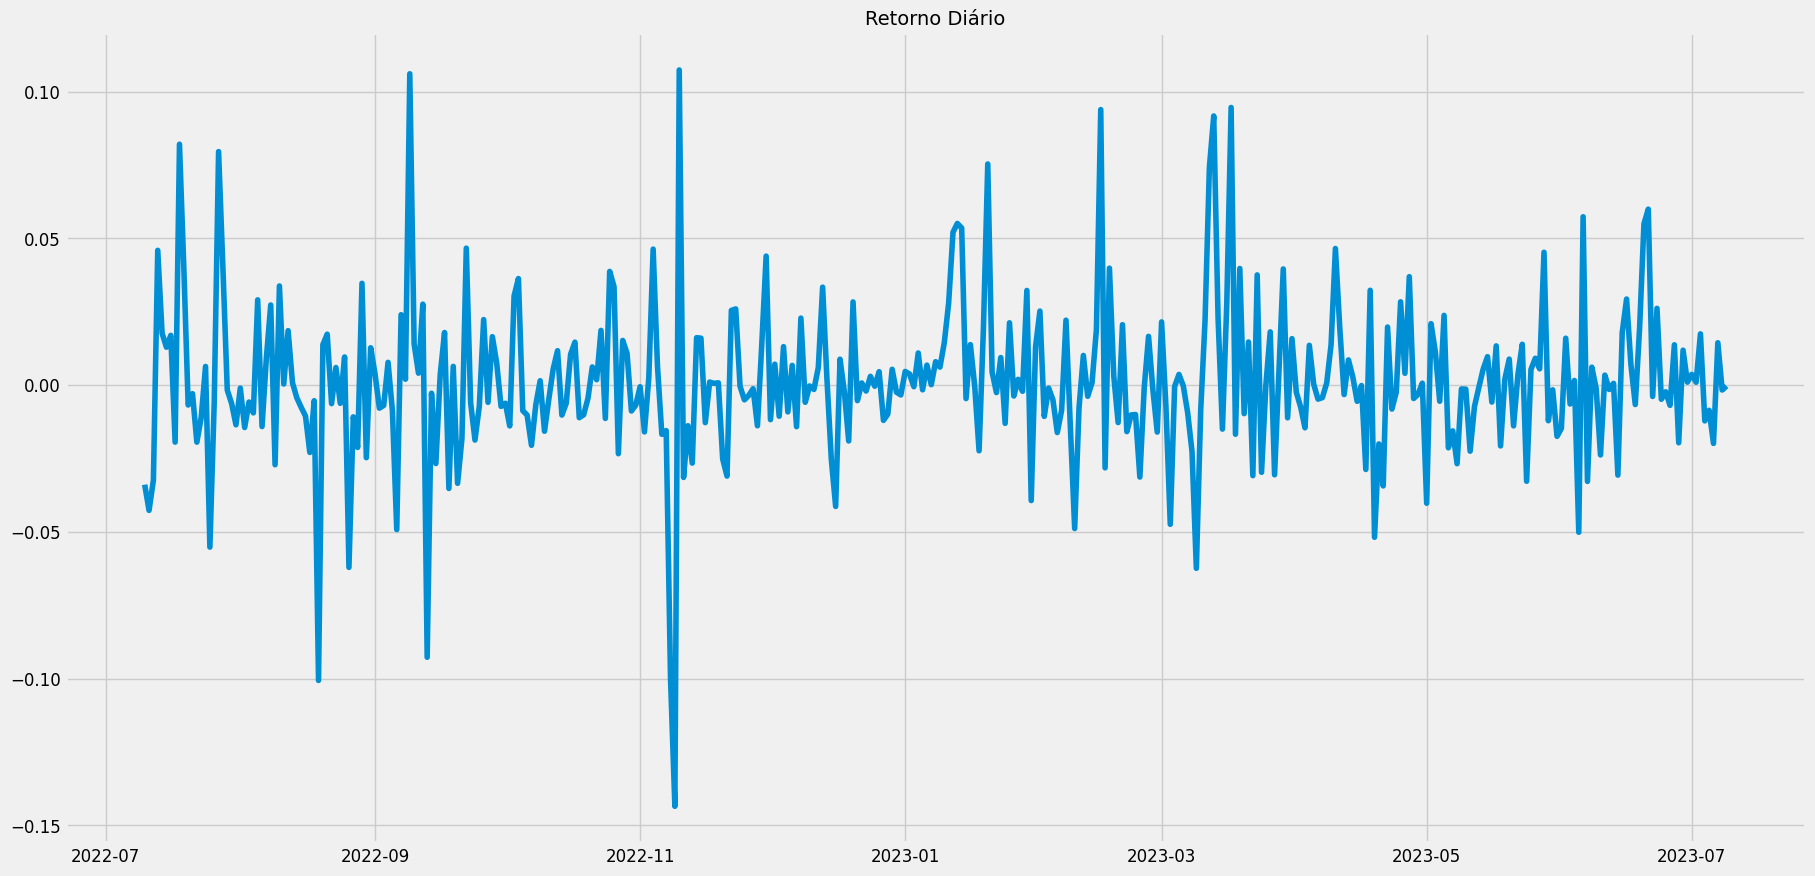

In [20]:
# Gráfico sobre o retorno diário

plt.plot(retorno_diario)
plt.title("Retorno Diário", size = 14)
plt.show()

Tivemos 3 grandes variações no período, concentradas nos períodos entre os meses de agosto - novembro de 2022, após esse período o retorno diário tem sido constante durante o tempo





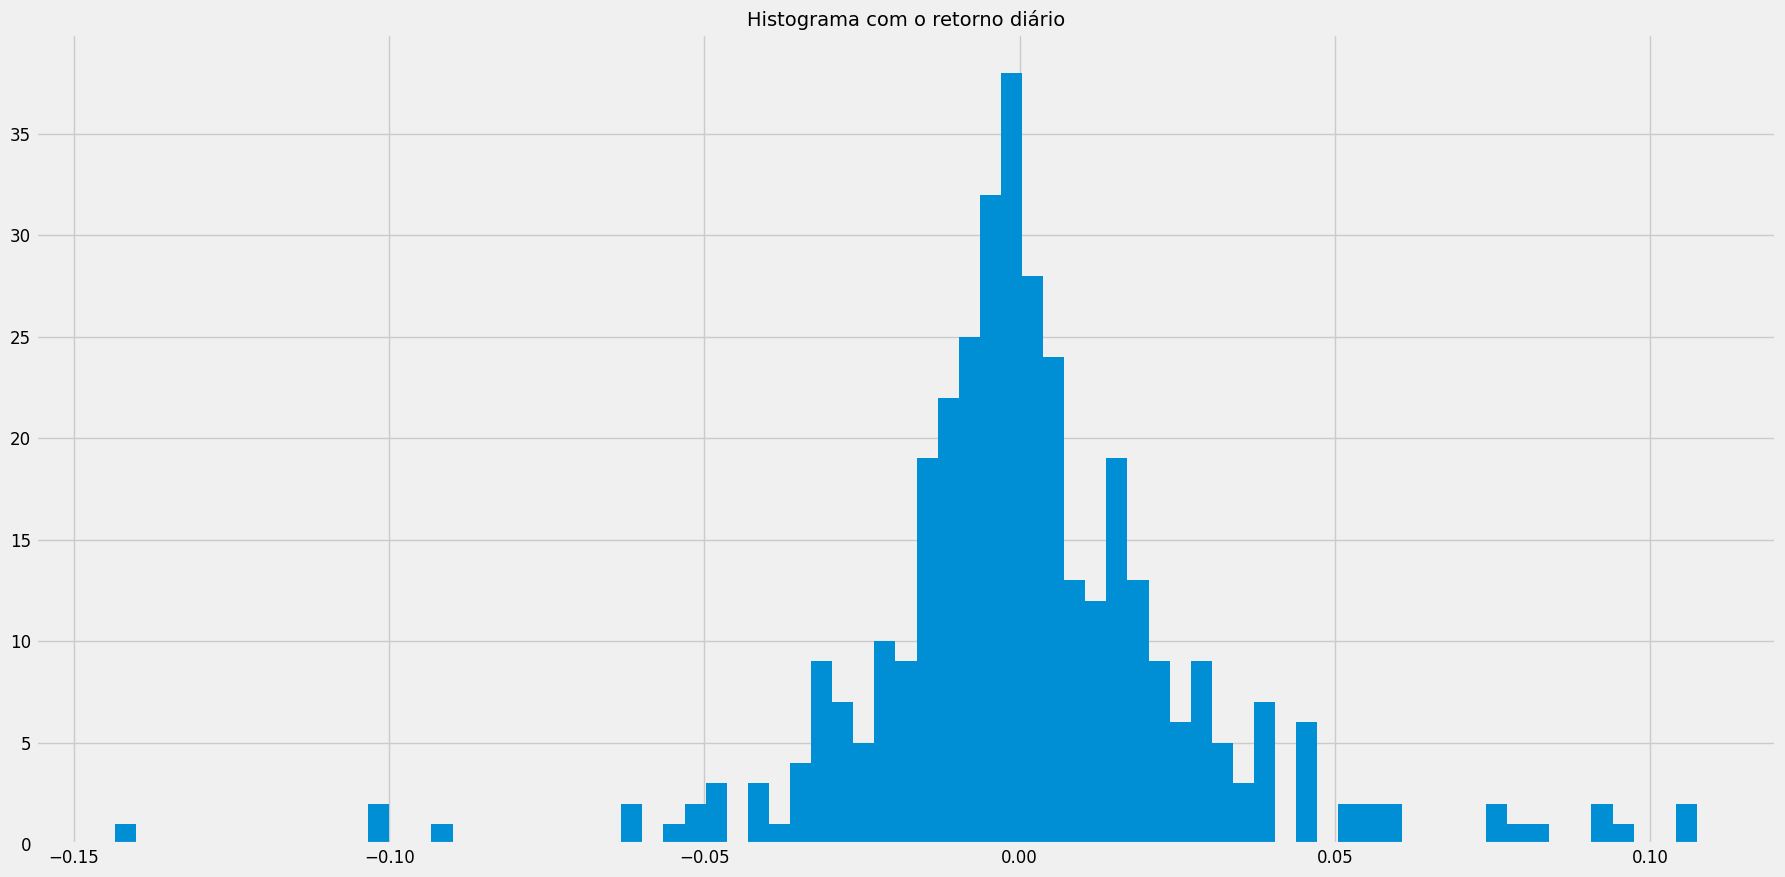

In [21]:
#Histograma com a distribuição do retorno diário

plt.hist(retorno_diario, bins = 75)
plt.title("Histograma com o retorno diário", size = 14)
plt.show()

Podemos perceber que a concentração entre as variações diárias está entre +/- 5% de variação.

# Transformando para Logaritmo

In [22]:
#Transformando de Log e diferenciação para calculo de retorno diário

log_retorno_diario = (np.log(Dados['Fechamento_x']) - np.log(Dados['Fechamento_x']).shift(-1)).dropna()


In [23]:
#Calculamos a média e desvio padrão após a transformação

log_media_retorno_diario = np.mean(log_retorno_diario)
log_desvio_retorno_diario = np.std(log_retorno_diario)

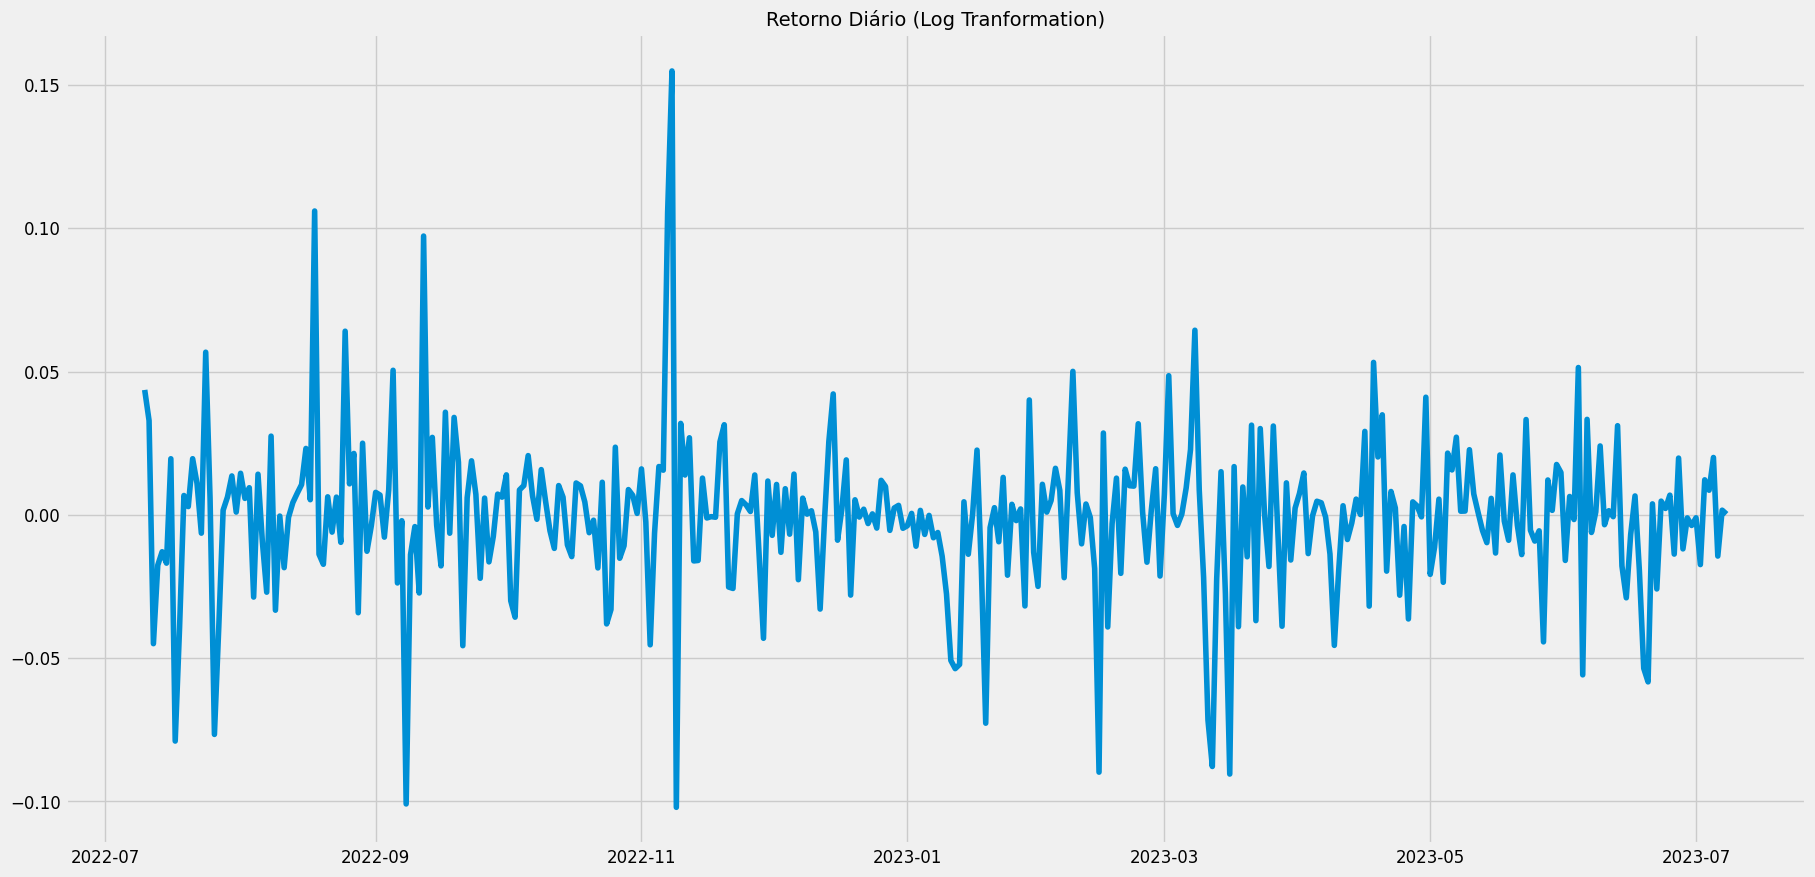

In [24]:
# Plotando a variação do retorno em escala logaritmica
plt.plot(log_retorno_diario)
plt.title("Retorno Diário (Log Tranformation)", size = 14)
plt.show()

Quando transformamos para escala logaritmica percebemos que temos mais variação, concentradas nos períodos entre os meses de agosto - novembro de 2022, como já vimos na outra analise, mas agora mostra uma outra variação no final do mês de fevereiro e inicio do mês de março.

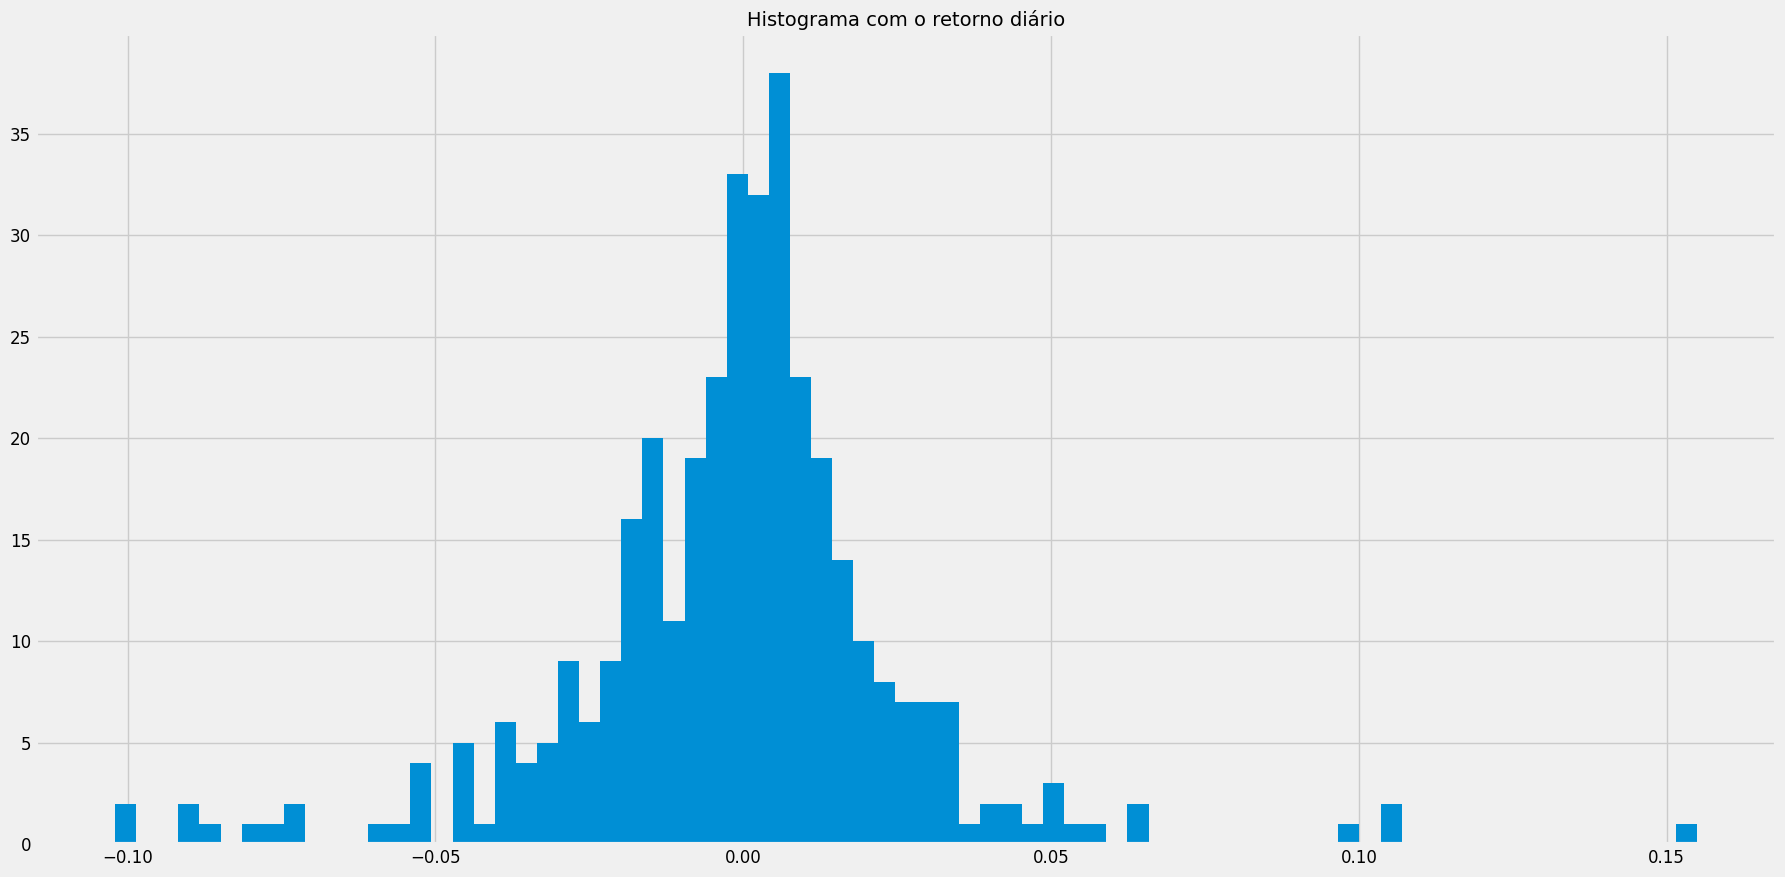

In [25]:
plt.hist(log_retorno_diario, bins = 75)
plt.title("Histograma com o retorno diário", size = 14)
plt.show()

No histograma mostra que a variação permanece entre os +/- 5%

# 4. Valor Histórico

Vamos calcular o valor histórico do preço do bitcoin

In [26]:
# Nível de Variância

var_level = 95
var = np.percentile(log_retorno_diario, 100 - var_level)
print("Certeza de que as perdas diarias nao excederão o VaR% em um determinado dia com base em valores históricos")
print("VAR 95%", var)

Certeza de que as perdas diarias nao excederão o VaR% em um determinado dia com base em valores históricos
VAR 95% -0.04484267091613842


In [35]:
# Var para os próximos 5 dias - raiz quadrada

var * np.sqrt(5)

-0.1002712604611383

# 5. Simulação de Monte Carlo

A idéia com essa simulação é projetar o comportamento da ação nos próximos 6 meses

In [36]:
# Número de dias a frente

dias_posteriores = 180

In [30]:
# Número de simulações

simulacoes  = 2500

In [31]:
# Ultimo valor da ação

ultimo_valor = 30284.29

In [38]:
# Criação de um array vazio com as dimensões, para armazenar os dados da simulação futura

results = np.empty((simulacoes, dias_posteriores))

In [40]:
# Loop para cada simulação

for s in range(simulacoes):

      # Calculo do retorno com dados randômicos seguindo uma distribuição normal
      random_returns = 1 + np.random.normal(loc = log_media_retorno_diario,
                                            scale = log_desvio_retorno_diario,
                                            size = dias_posteriores)
      result = ultimo_valor * (random_returns.cumprod())
      results[s, :] = result

In [42]:
# Definindo o índice da série simulada

index = pd.date_range("2023-07-10", periods = dias_posteriores, freq = "D")
resultados = pd.DataFrame(results.T, index = index) # faremos a matriz transposta do resultados
media_resultados = resultados.apply("mean", axis = 1)

## 5.1 Resultado da Simulação de Monte Carlo

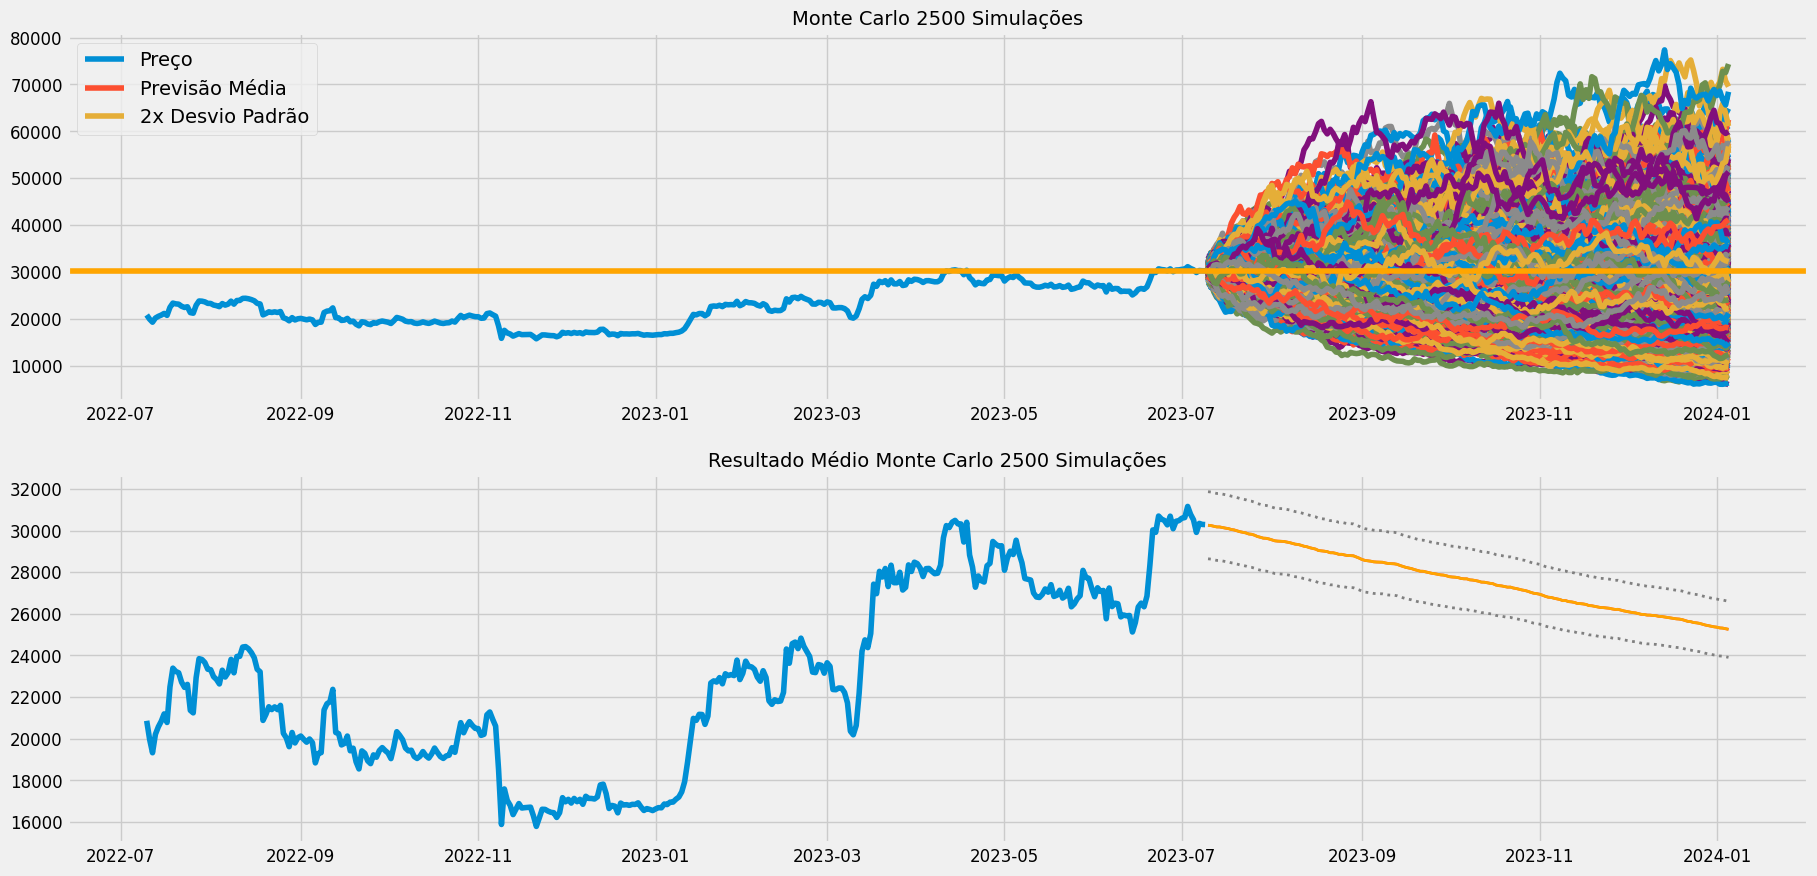

In [43]:
# Dividindo a área de plotagem em 2 subplots

fig, ax = plt.subplots(nrows = 2, ncols = 1)

# Plotar o gráfico

ax[0].plot(Dados['Fechamento_x'][:"2024-01-31"])

ax[0].plot(resultados)

ax[0].axhline(30284.29, c = 'orange')

ax[0].set_title(f"Monte Carlo {simulacoes} Simulações", size = 14)

ax[0].legend(["Preço Histórico", "Último Preço = 22307,00"])

ax[1].plot(Dados['Fechamento_x'][:"2024-01-31"])

ax[1].plot(resultados.apply("mean", axis = 1), lw = 2)

ax[1].plot(media_resultados.apply((lambda x: x * (1+1.96 * log_desvio_retorno_diario))),
           lw = 2, linestyle = 'dotted', c = 'gray')

ax[1].plot(media_resultados, lw = 2, c = 'orange')

ax[1].plot(media_resultados.apply((lambda x: x * (1-1.96 * log_desvio_retorno_diario))),
           lw = 2, linestyle = 'dotted', c = 'gray')

ax[1].set_title(f"Resultado Médio Monte Carlo {simulacoes} Simulações", size=14)

ax[0].legend(["Preço", "Previsão Média", "2x Desvio Padrão"])

plt.show()

In [ ]:
#Utilizando a função ROLLING
#É uma função do pandas que permite calcular estatísticas em janelas deslizantes de dados, importante para calcular médias móveis, desvios padrão, somatórios mínimos e máximos, entre outras estatísticas

In [ ]:
from pandas.core import window
Periodo = 5 #retirando uma média a cada 5 dias
Dados['Close'].rolling(window=Periodo).mean()

#Tamanho da imagem
plt.figure(figsize=(12,6))
plt.plot(Dados['Close'])
#Cria os dados da média movel e coloca junto com o grafico anterior
plt.plot(Dados['Close'].rolling(window=Periodo).mean())
plt.plot(Dados['Close'].rolling(window=Periodo + 50).mean())
plt.title('Preço do Fechamento ações WEGE3')
plt.legend(['Close', 'Media 5 dias', 'Media 50 dias'])
plt.ylabel('Valor de Fechamento')
plt.xlabel('Periodo');

Podemos perceber que as ações estão com tendência de crescimento conforme mostra a linha em verde, onde realizamos uma análise colocando um período onde agrupa os dados a cada 50 dias.

In [ ]:
#Aplicar a media movel nos dados utilizando o Plotly

#retirando uma média a cada 5 dias
Periodo = 5
Dados['Media_Movel'] = Dados['Close'].rolling(window=Periodo).mean()

Figure = px.line(
    Dados,
    y='Close',
    title='Analise Fechamento WEGE3'
)

Figure.show()

In [ ]:
#Gráfico de Candlestick

#É um estilo de grafico financeiro que descreve abertura, alta, baixa e fechamento para uma determinada xcoordenada.
#As caixas representam a dispersão entre os valores open close as linhas representam a dispersão entre os valores low e high

In [ ]:
#Grafico Candlestick

Grafico_Candlestick = go.Figure(
    data=[
        go.Candlestick(
            x=Dados.index,
            open=Dados['Open'],
            high=Dados['High'],
            low=Dados['Low'],
            close=Dados['Close']
            #voce pode mudar as cores conforme comandos abaixo
            #increasing_line_color='cyan',
            #decreasing_line_color='cyan'
         )
    ]
)

Grafico_Candlestick.update_layout(
    xaxis_rangeslider_visible=False,
    title='Analise de Fechamento',
    xaxis_title='Periodo',
    yaxis_title='Preço de Fechamento'
)

Grafico_Candlestick.show()

In [ ]:
#Criar a figura

Figura = make_subplots(
    rows=2,
    cols=1,
    specs=[
        [{'type':'scatter'}],
        [{'type':'scatter'}],
    ],
    vertical_spacing=0.075,
    shared_xaxes=True,
    subplot_titles=('Cotação', 'Fechamento')
)

#Layout e Dimensão

Figura.update_layout(
    width=1000,
    height=800,
    title_text='<b>Advanced Analytics<\b> <br> Follow up WEGE3'
)

#Adicionando um grafico na primeira posição
Figura.add_trace(
    go.Candlestick(
            x=Dados.index,
            open=Dados['Open'],
            high=Dados['High'],
            low=Dados['Low'],
            close=Dados['Close']
    ),
    row=1, col=1,
)

Figura.update_layout(
    xaxis_rangeslider_visible=False
)

#Adicionando um grafico na segunda posição

Figura.add_trace(
    go.Scatter(
            x=Dados.index,
            y=Dados['Close'],
            mode='lines',
            name='Fechamento'
            #line=dict(color='green')
    ),
    row=2, col=1
)

#Adicionando média movel

Figura.add_trace(
    go.Scatter(
            x=Dados.index,
            y=Dados['Media_Movel'],
            mode='lines',
            name='Media_Movel'
            #line=dict(color='black')
    ),
    row=2, col=1
)

Figura.update_layout(
    legend=dict(
        orientation='h',
        yanchor='bottom',
        y=1.02,
        xanchor='right',
        x=1,
        font=dict(size=10)
    )

)

Figura.add_annotation(
    showarrow=False,
    text='Análise realizada evento Data Viking',
    font=dict(size=14),
    xref='x domain',
    x=1,
    yref='y domain',
    y=-1.4
)

Figura.add_annotation(
    showarrow=False,
    text='By: @Lerina Mesquita Mastruian',
    font=dict(size=14),
    xref='x domain',
    x=0,
    yref='y domain',
    y=-1.4
)

Figura.show()

Podemos verificar que quem adquiriu a partir de **janeiro de 2019** com preço médio de **R$ 9,19**.

Em **janeiro de 2021** a ação chegou no seu preço máximo de **R$ 45,14** onde obteve uma valorização de **491%**